<a href="https://colab.research.google.com/github/1122vamsi/new/blob/master/test_as_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/tensorflow/tpu/

Cloning into 'tpu'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 9426 (delta 2), reused 6 (delta 2), pack-reused 9413
Receiving objects: 100% (9426/9426), 24.12 MiB | 29.03 MiB/s, done.
Resolving deltas: 100% (6777/6777), done.


In [35]:
from PIL import Image
import cv2
import numpy as np
from IPython.display import display
import json
import os

In [36]:

from IPython import display
from PIL import Image
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils

In [37]:
image_path = '/content/drive/My Drive/Image_processing_training/vamsi/dog_cat.jpg'

In [38]:
def load_model(image_path, use_tpu):
  session = create_session(use_tpu)
  saved_model_dir = "/content/drive/My Drive/mask-rcnn-model/1555659850"
  _ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

  id_mapping_dir = os.path.join(saved_model_dir, "id_mapping.json")
  with open(id_mapping_dir) as f:
    ID_MAPPING = json.load(f)
  category_index = {int(k): {'id': int(k), 'name': ID_MAPPING[k]} for k in ID_MAPPING}
  temp = img_read(session, image_path, category_index)
  return temp

In [39]:
def create_session(use_tpu):
  # use_tpu = False
  if use_tpu:
    import os
    import pprint

    assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
    TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    print('TPU address is', TPU_ADDRESS)

    session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
    print('TPU devices:')
    pprint.pprint(session.list_devices())
  else:
    session = tf.Session(graph=tf.Graph())
  return session

In [47]:
def img_read(session, image_path, category_index):
  with open(image_path, 'rb') as f:
    np_image_string = np.array([f.read()])
    
  image = Image.open(image_path)
  width, height = image.size
  np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

  num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})

  num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
  detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
  detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
  detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
  instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
  ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
  processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
  segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)
  max_boxes_to_draw = 50
  min_score_thresh = 0.45

  image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
      np_image,
      detection_boxes,
      detection_classes,
      detection_scores,
      category_index,
      instance_masks=segmentations,
      use_normalized_coordinates=False,
      max_boxes_to_draw=max_boxes_to_draw,
      min_score_thresh=min_score_thresh)
  output_image_path = 'test_results.jpg'
  Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
  display.display(display.Image(output_image_path, width=1024))
  # return detection_classes

#display.display(display.Image(image_path, width=1024))

In [44]:
image_path = ['/content/drive/My Drive/Image_processing_training/vamsi/dog_cat.jpg', '/content/drive/My Drive/Image_processing_training/vamsi/20170829_073843~2.jpg']

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/mask-rcnn-model/1555659850/variables/variables


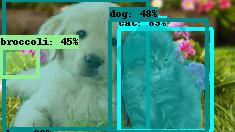

None
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/mask-rcnn-model/1555659850/variables/variables


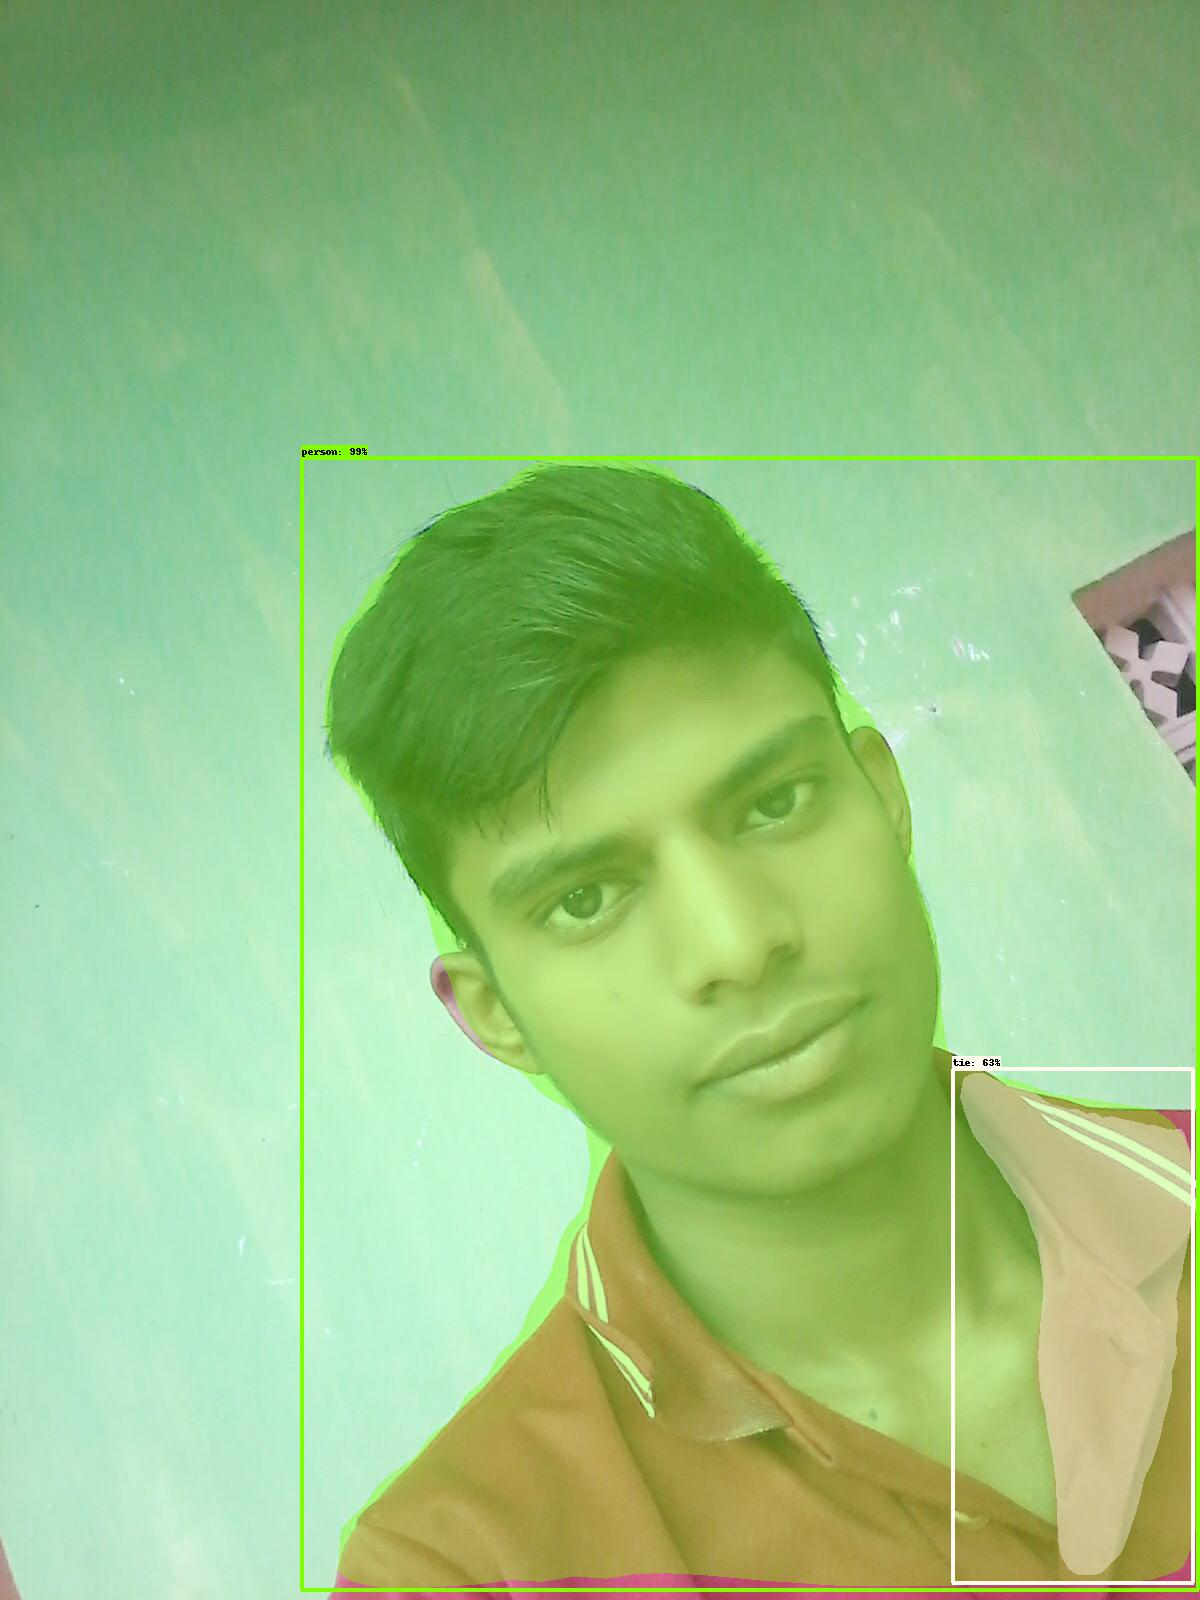

None


In [48]:
for ele in image_path:
  result = load_model(ele, False)
  print(result)

In [42]:
result

array([18, 17, 18, 56, 17, 64, 63, 88, 64, 64, 64, 62, 88, 56, 23, 64, 65],
      dtype=int32)

In [ ]:
t

In [42]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = t.run(
  ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
  feed_dict={'Placeholder:0': np_image_string})

RuntimeError: ignored